In [5]:
import numpy as np

import adaptive_latents
from adaptive_latents import AnimationManager, Pipeline, CenteringTransformer, proSVD, Bubblewrap, VanillaOnlineRegressor, NumpyTimedDataSource, KernelSmoother, Concatenator, sjPCA, ZScoringTransformer
import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Video, Image, display

from importlib import reload
import socket
hostname = socket.gethostname()
rng = np.random.default_rng()



In [6]:
!echo $(hostname) $(git rev-parse --short HEAD)

tycho 85c7da5


/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



## Combination and prediction video


In [7]:
%%time
%matplotlib inline
shortrun = hostname == 'tycho' and True


d = datasets.Odoherty21Dataset(neural_lag=0, drop_third_coord=False)

streams = []
streams.append((d.neural_data, 0))
streams.append((d.beh_pos, 1))
streams.append((d.beh_pos, 3))

# this pipeline makes the latent space
p1 = Pipeline([
    CenteringTransformer(init_size=100, input_streams={0:'X'}, output_streams={0:0}),
    KernelSmoother(tau=0.04/d.bin_width, input_streams={0:'X'}, output_streams={0:0}),
    zst:=ZScoringTransformer(init_size=10/d.beh_pos.dt, freeze_after_init=False, input_streams={1:'X'}, output_streams={1:1}),
    Concatenator(input_streams={0: 0, 1: 1}, output_streams={0:2, 1:2, 'skip':-1}),
    pro:=proSVD(k=6, init_size=100, input_streams={2:'X'}, output_streams={2:2}),
    jpca:=sjPCA(init_size=100, input_streams={2:'X'}, output_streams={2:2}),
])

# this pipeline handles the prediction and regression
p2 = Pipeline([
    bw:=Bubblewrap(
        num=1100,
        M=500,
        lam=1e-3,
        nu=1e-3,
        eps=1e-4,
        step=1,
        num_grad_q=1,
        sigma_orig_adjustment=100, # 0
        input_streams={2:'X'},
        output_streams={2:2},
        log_level=1,
    ),
    reg:=VanillaOnlineRegressor(
        input_streams={2:'X', 3:'Y'},
        output_streams={2:2},
    ),
])



video_dt = 0.05
video_ts = (np.arange(50)*video_dt + 35) if shortrun else (np.arange(200)*video_dt + 600)
streams.append( (NumpyTimedDataSource(np.nan * video_ts, video_ts), 'video') )


pbar = tqdm(total=video_ts[-1])
latents = []
latent_ts = []

latent_predictions = []
beh_predictions = []
prediction_ts = []

pred_am = None
bw_am = None
with (
    plt.ioff(),
    AnimationManager(fps=1/video_dt, filetype='gif') as bw_am, 
    (vid:=pf.PredictionVideo(d, fps=1/video_dt, filetype='gif')).am as pred_am
):
    for output, stream in Pipeline().streaming_run_on(streams, return_output_stream=True):
        # dim reduction part of pipeline
        output, stream = p1.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            latents.append(output)
            latent_ts.append(output.t)

        # prediction part of pipeline
        output, stream = p2.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            prediction_t = output.t + bw.dt
            
            # alpha_pred = bw.get_alpha_at_t(0, relative_t=True)
            
            alpha_pred = bw.get_alpha_at_t(prediction_t)
            
            # alpha_pred[np.argmax(bw.alpha)] = 0
            # alpha_pred[alpha_pred < alpha_pred.max()] = 0
            # alpha_pred = alpha_pred / alpha_pred.sum()
            
            latent_prediction = np.array(bw.mu[np.argmax(alpha_pred)])
            beh_prediction = reg.predict(alpha_pred)

            latent_predictions.append(latent_prediction)
            beh_predictions.append(beh_prediction)
            prediction_ts.append(prediction_t)
            
        
        if stream == 'video':
            
            if bw_am is not None:
                if output.t == video_ts[0]:
                    ax: plt.Axes = bw_am.axs[0,0]
                    ax.text(0,1, f"p1={str(p1)}\np2={str(p2)}\nmin video t={video_ts.min()}", transform=ax.transAxes, fontsize='xx-small', verticalalignment='top', wrap=True)
                    bw_am.grab_frame()
                    
                ax: plt.Axes = bw_am.axs[0,0]
                ax.cla()
                bw.scatter_data_with_decay(ax,np.squeeze(latents))
                bw.show_active_bubbles_and_connections_2d(ax, np.squeeze(latents))
                bw_am.grab_frame()
                
            if pred_am is not None:
                if output.t == video_ts[0]:
                    ax = vid.neural_data_ax
                    ax.text(0,1, f"p1={str(p1)}\np2={str(p2)}\nmin video t={video_ts.min()}", transform=ax.transAxes, fontsize='xx-small', verticalalignment='top', wrap=True)
                    ax.set_zorder(1)
                    pred_am.grab_frame()
                
                vid.plot_for_video_t(output.t, latents, latent_ts, latent_predictions, beh_predictions, prediction_ts, streams)
            
            if output.t == video_ts[-1]:
                break

        pbar.update(round(output.t,1) - pbar.n)


latents = np.squeeze(latents)
latent_predictions = np.squeeze(latent_predictions)
beh_predictions = np.squeeze(beh_predictions)
prediction_ts = np.squeeze(prediction_ts)

plt.close()
plt.close()

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/37.45 [00:00<?, ?it/s]

CPU times: user 34.8 s, sys: 3.13 s, total: 37.9 s
Wall time: 32.2 s


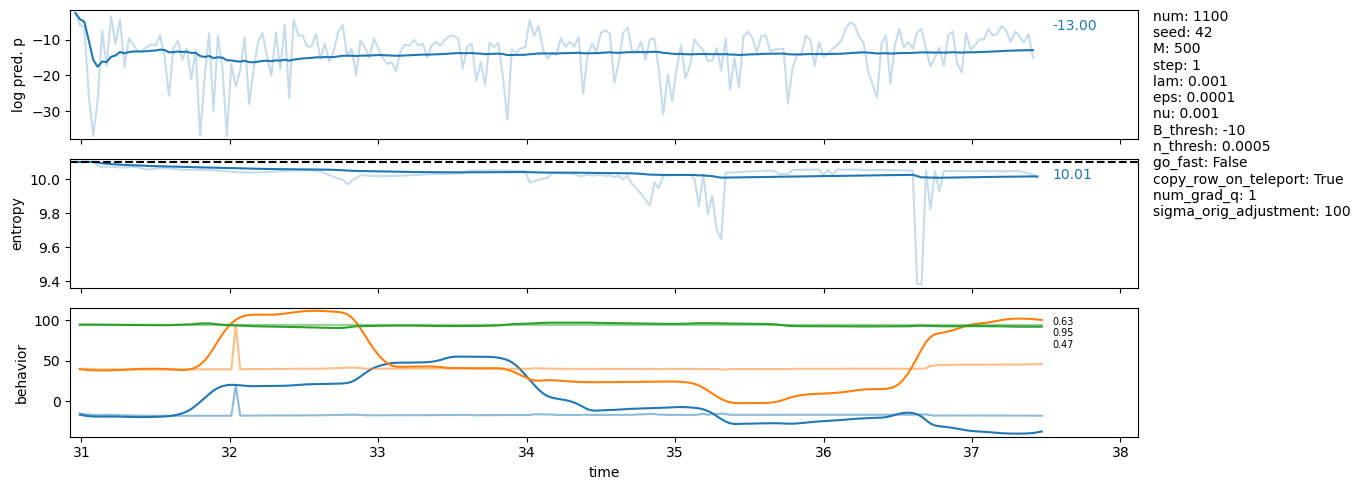

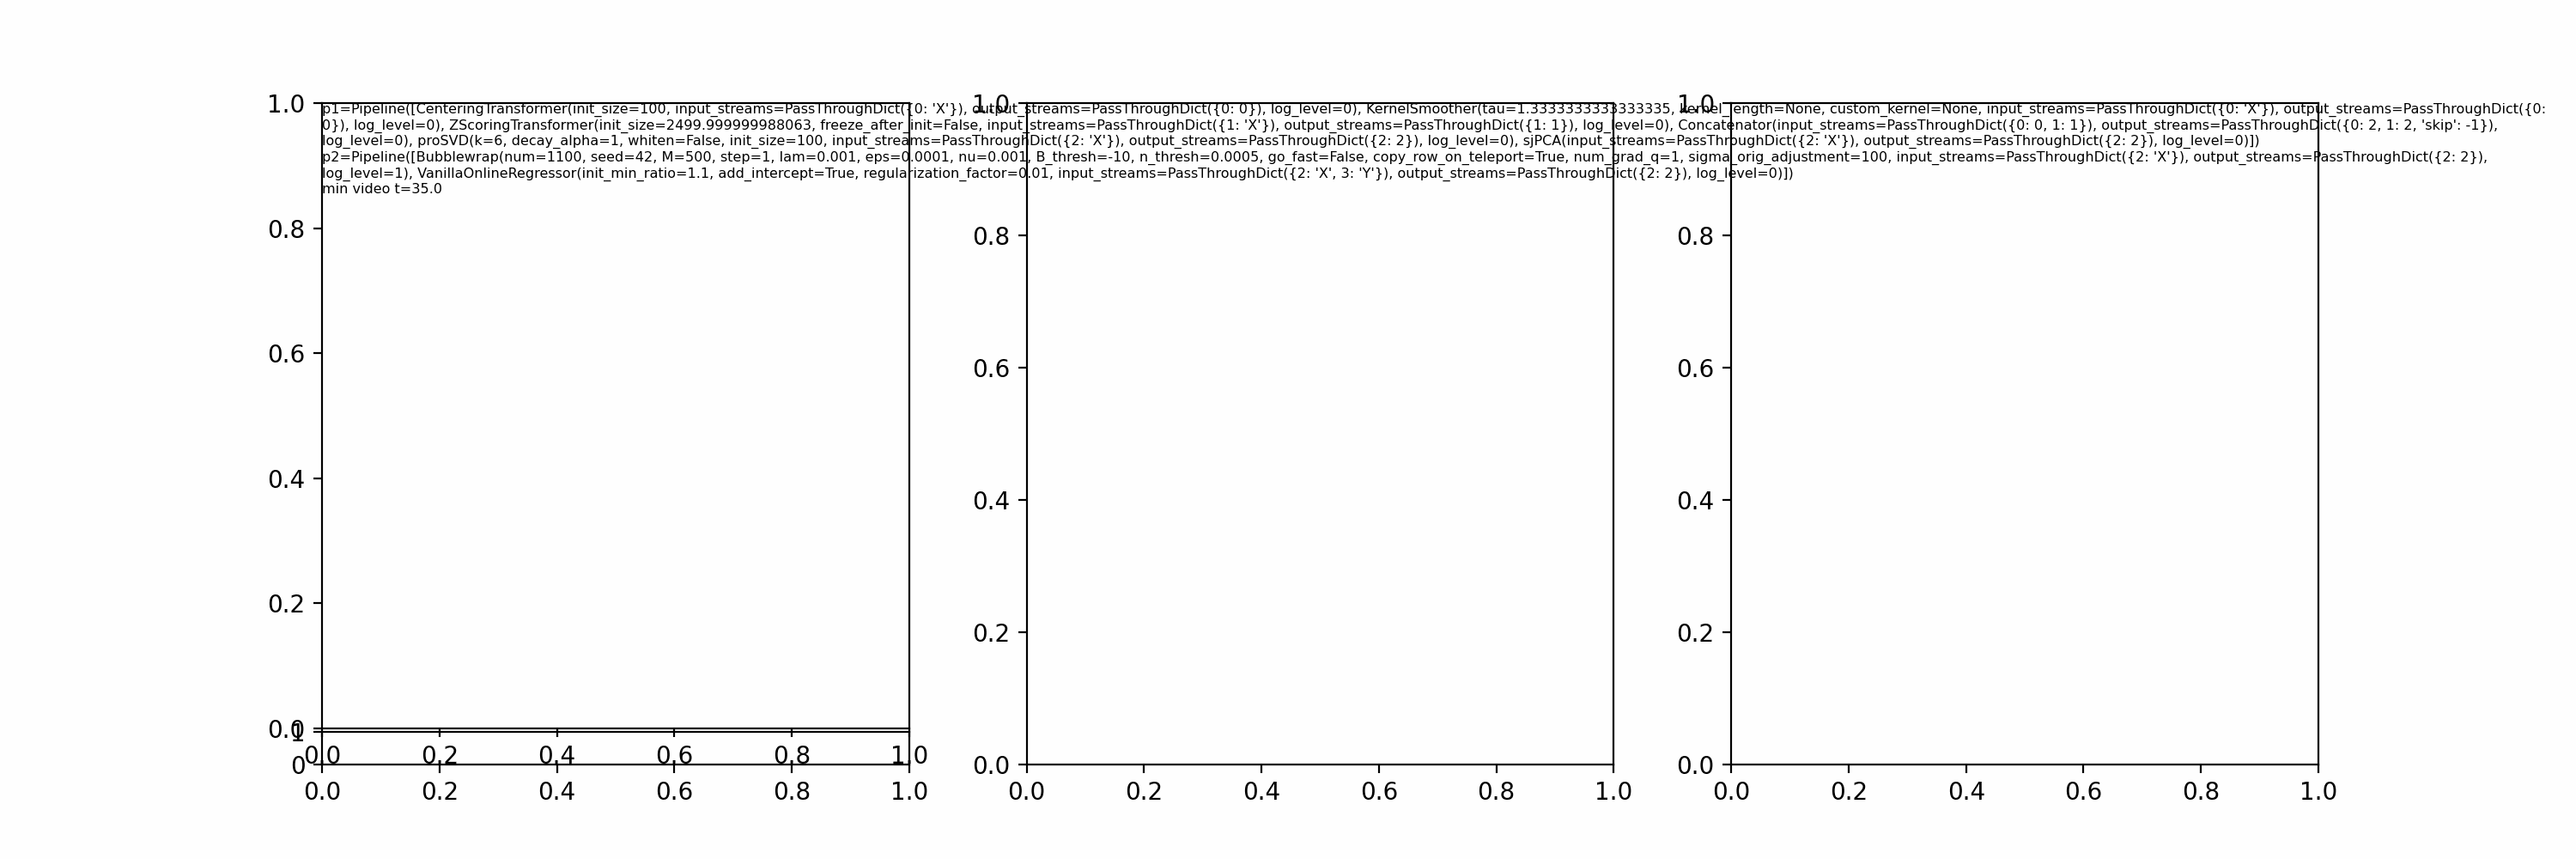

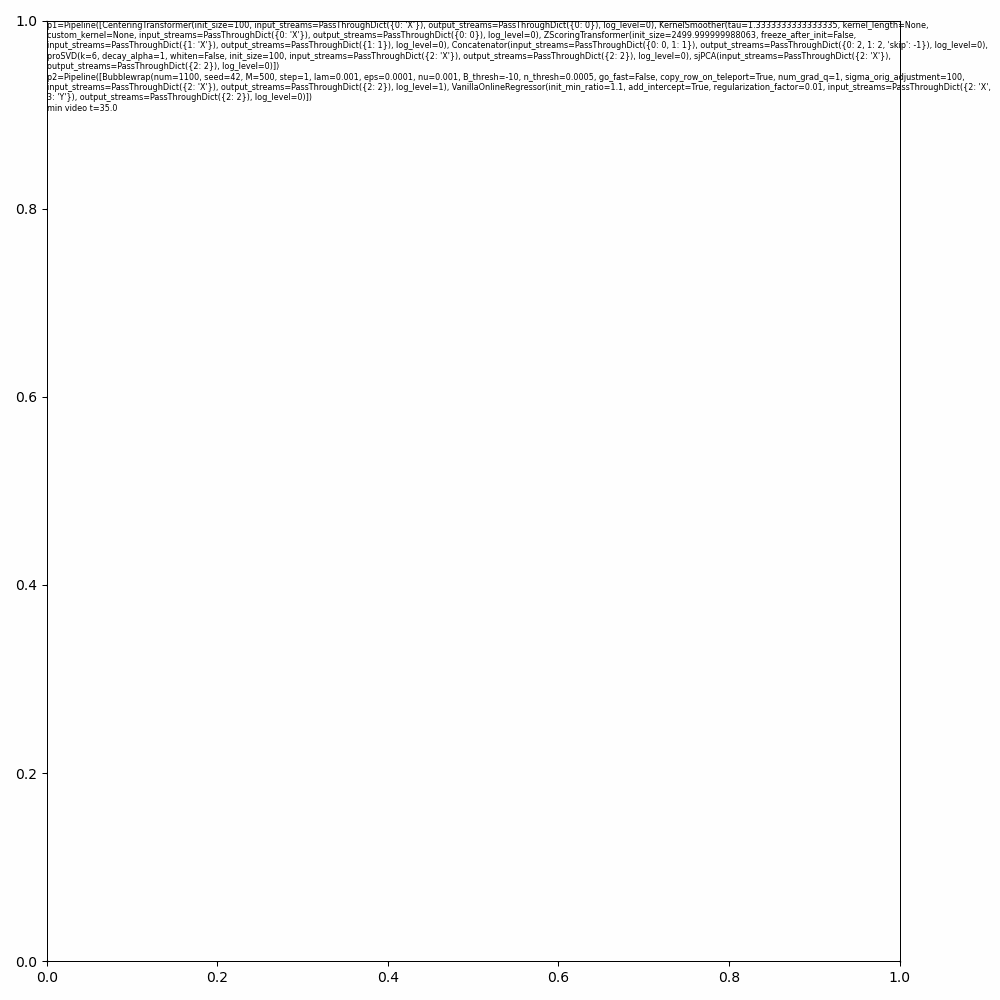

Text(0.5, 1.0, 'alpha')

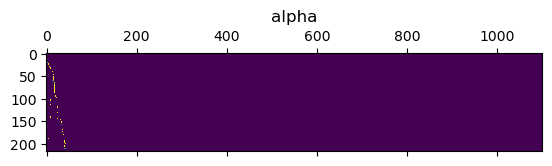

In [8]:

behavior_dict = dict(
    true_behavior=np.squeeze(streams[2][0].a),
    true_behavior_t=streams[2][0].t,
    predicted_behavior=beh_predictions,
    predicted_behavior_t=prediction_ts,
)
adaptive_latents.bubblewrap.Bubblewrap.compare_runs([bw], [behavior_dict], t_in_samples=False)
plt.show()

if pred_am is not None:
    display_class = Image if 'gif' in str(pred_am.outfile) else Video
    display(display_class(pred_am.outfile, embed=True, width=900))


if bw_am is not None:
    display_class = Image if 'gif' in str(bw_am.outfile) else Video
    display(display_class(bw_am.outfile, embed=True, width=700))

fig, ax = plt.subplots()
ax.matshow(bw.log['alpha'][-300:])
ax.set_title('alpha')

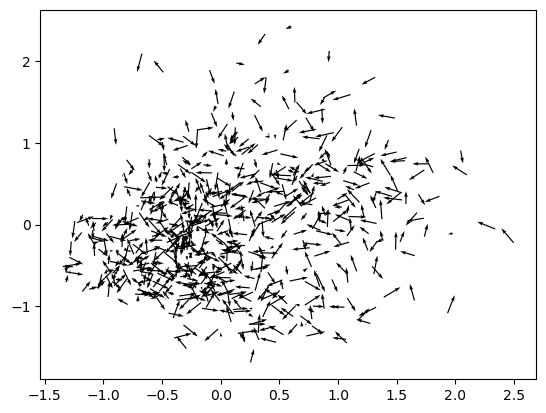

In [9]:

%matplotlib inline
fig, ax = plt.subplots()
s = np.array(latent_ts) > 10
# ax.scatter(latents[s,0], latents[s,1], s=5, alpha=.1, c='C0', edgecolors='none')
sub_latents = latents[s]
d_sub_latents = np.diff(sub_latents, axis=0)
d_sub_latents = d_sub_latents / np.linalg.norm(d_sub_latents, axis=1)[:, np.newaxis]

ax.quiver(sub_latents[:-1,0], sub_latents[:-1,1], d_sub_latents[:,0], d_sub_latents[:,1], scale=1/20, units='dots')

x1, x2, y1, y2 = ax.axis()

x_points = np.linspace(x1, x2, 10)
y_points = np.linspace(y1, y2, 10)
mgrid = np.meshgrid(*[np.linspace(sub_latents[:,i].min(),sub_latents[:,i].max(), 10) for i in range(sub_latents.shape[1])])

# arrows = np.zeros(shape=(len(points), sub_latents.shape[1]))

# ax.quiver(points[:,0], points[:,1])


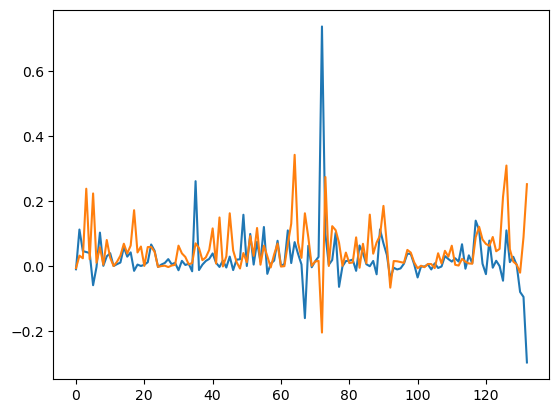

In [10]:
e1, e2 = np.zeros(6), np.zeros(6)
e1[0] = 1
e2[1] = 1

plt.plot(pro.inverse_transform(jpca.inverse_transform(e1, 2), 2))
plt.plot(pro.inverse_transform(jpca.inverse_transform(e2, 2), 2))



In [11]:
jpca.get_U()

array([[ 0.41972769, -0.37692822,  0.16462245, -0.66255433,  0.45998366,
         0.06395333],
       [-0.41066472,  0.12851516,  0.88959525, -0.06651606,  0.04786065,
         0.12939708],
       [ 0.18696846,  0.49395626,  0.00438639, -0.58741539, -0.61316189,
        -0.00253374],
       [ 0.22270427, -0.10309857,  0.26502964,  0.10219406, -0.10734962,
        -0.92063305],
       [-0.74482744, -0.30864227, -0.28929489, -0.43552178, -0.05947353,
        -0.27030387],
       [-0.12593983,  0.70108974, -0.1660369 , -0.1068536 ,  0.6285665 ,
        -0.24193088]])

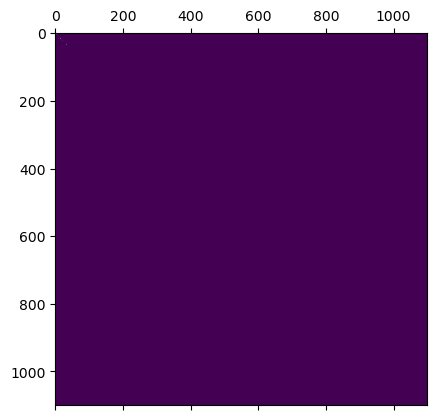

In [12]:
plt.matshow(bw.A)

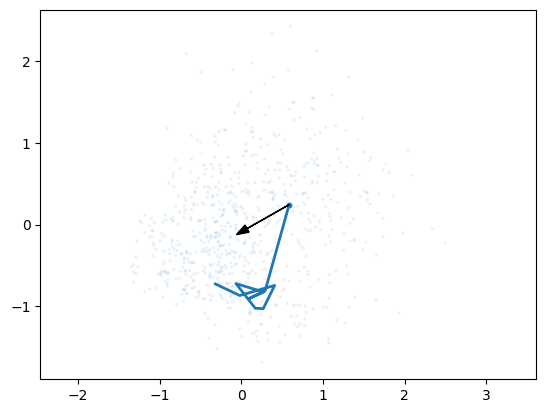

In [13]:

fig, ax = plt.subplots()

dim_1, dim_2 = 0,1
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)

ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')

ax.axis('equal');



In [14]:
assert isinstance(d, datasets.Zong22Dataset)
desired_pattern = np.mean(latents[-101:-1], axis=0)
current_pattern = latents[-1]
desired_stim = desired_pattern - current_pattern

desired_pattern = (desired_stim @ pro.Q.T)[:d.neural_data.a.shape[-1]]

near_zero = np.abs(desired_stim) < 100
print(near_zero.sum())
desired_stim[near_zero] = np.nan


fig, ax = plt.subplots()
d.show_stim_pattern(ax, np.abs(desired_pattern))


AssertionError: 

## Intro video

In [ ]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()